# Week 8 Supervised Learning

## Practicum 8-2

PR8-2: Classificatiemodellen in Machine Learning. Great Outdoors wil graag weten wat de retourredenen gaan zijn op basis van een set onafhankelijke variabelen. Daarom wil zij een model trainen op basis van reeds bekende data, zodat deze volgend jaar in gebruik kan worden genomen. Let op: de retourreden kan ook "n.v.t." zijn, niet elke order wordt namelijk geretourneerd; je zult dit moeten aanpakken door een join tussen "returned_item" en "order_details". Je doet dus het volgende met de reeds bekende data:

* Bedenk met welke onafhankelijke variabelen dit naar verwachting het beste voorspeld kan worden en zet deze samen met de afhankelijke variabele in één DataFrame.
* Pas waar nodig Dummy Encoding toe.
* Snijd dit DataFrame horizontaal en verticaal op de juiste manier.
* Train het classificatiemodel.
* Evalueer de performance van je getrainde classificatiemodel a.d.h.v. een confusion matrix.


### Imports

Hier staan alle imports die gebruikt zullen worden voor de practicumopdrachten 8-2.

In [418]:
import sqlite3 as sql
import warnings as warn
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree, metrics
from sklearn.tree import DecisionTreeClassifier

warn.filterwarnings("ignore")

### SQLite connections

Hier maken we de connectie naar de SQLite Databases.

In [419]:
conn = sql.connect("Great_Outdoors_Data_SQLite/go_sales.sqlite")

### Tables to use for the classification model

De tabellen die we gebruiken voor het classificatie model die we ook snel kunnen uitlezen.

In [420]:
# return_reason
# returned_item
# order_details

return_reason = pd.read_sql_query(f"SELECT * FROM return_reason", conn)
returned_item = pd.read_sql_query(f"SELECT * FROM returned_item", conn)
order_details = pd.read_sql_query(f"SELECT * FROM order_details", conn)
product = pd.read_sql_query("SELECT * FROM product", conn)
order_details

# TRIAL column not taken into account
# return_reason => 2 columns
# returned_item => 5 columns
# order_details => 7 columns
# 14 columns

,ORDER_DETAIL_CODE,ORDER_NUMBER,PRODUCT_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,TRIAL879
0,100000,8462,96,16,16.1,22.54,22.54,T
1,100001,9111,96,20,16.1,22.54,22.54,T
2,100002,8451,96,24,16.1,22.54,22.54,T
3,100003,8453,96,18,16.1,22.54,22.54,T
4,100004,8439,96,20,16.1,22.54,22.54,T
...,...,...,...,...,...,...,...,...
43058,99995,8459,95,146,2.76,5.55,5.55,T
43059,99996,8457,95,172,2.76,5.55,5.55,T
43060,99997,9267,95,192,2.76,5.55,5.55,T
43061,99998,8441,95,192,2.76,5.55,5.55,T


### Merging the used tables together

We zullen hier alle tabellen samenvoegen om dit te kunnen gebruiken voor het model en we vegen de TRIAL kolommen schoon.

In [421]:
df = returned_item.merge(order_details, how="outer", on="ORDER_DETAIL_CODE").merge(return_reason, how="outer", on="RETURN_REASON_CODE").merge(product, on="PRODUCT_NUMBER")
df = df[df.columns.drop(list(df.filter(regex="TRIAL")))]
df = df.drop(columns=["PRODUCT_NAME", "DESCRIPTION", "PRODUCT_IMAGE"])
df = df.dropna()
df

,RETURN_CODE,RETURN_DATE,ORDER_DETAIL_CODE,RETURN_REASON_CODE,RETURN_QUANTITY,ORDER_NUMBER,PRODUCT_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,RETURN_DESCRIPTION_EN,INTRODUCTION_DATE,PRODUCT_TYPE_CODE,PRODUCTION_COST,MARGIN,LANGUAGE
0,1491,1-8-2021 04:10:24,84858,5,8,7446,6,8,87.63,123.56,123.56,Unsatisfactory product,5-3-2013,1,85.11,.28,EN
1,1918,25-4-2022 22:56:33,98653,5,22,8239,6,22,85.11,120,120,Unsatisfactory product,5-3-2013,1,85.11,.28,EN
2,1566,28-7-2020 09:24:15,47783,4,20,1415,6,20,92,129.72,129.72,Wrong product shipped,5-3-2013,1,85.11,.28,EN
3,1917,15-10-2022 17:45:46,98648,3,28,8317,6,28,85.11,120,107.79,Wrong product ordered,5-3-2013,1,85.11,.28,EN
300,1502,27-8-2022 20:52:27,85850,5,30,7457,29,30,41.18,70,70,Unsatisfactory product,5-3-2013,4,41.18,.4,EN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40169,2287,11-5-2021 06:15:02,60732,1,2,5121,51,14,34.47,68.94,68.94,Defective product,10-1-2021,8,35,.5,EN
40516,2298,14-12-2021 11:28:50,100250,1,6,9254,43,52,126.51,189.77,189.77,Defective product,10-1-2021,6,126.66,.33,EN
40830,2344,18-8-2022 17:42:13,50150,1,8,1363,90,168,2.5,7,4.75,Defective product,15-2-2011,15,2.5,.63,EN
41191,2347,28-8-2020 12:30:24,109838,1,6,9467,93,90,1.79,4.5,4.5,Defective product,15-2-2011,16,2,.6,EN


### Remove return_date column

We moeten de retourdatum verwijderen, zodat het model werkt.

In [422]:
df = df.drop(columns=["RETURN_DATE", "INTRODUCTION_DATE", "LANGUAGE"])
df

,RETURN_CODE,ORDER_DETAIL_CODE,RETURN_REASON_CODE,RETURN_QUANTITY,ORDER_NUMBER,PRODUCT_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,RETURN_DESCRIPTION_EN,PRODUCT_TYPE_CODE,PRODUCTION_COST,MARGIN
0,1491,84858,5,8,7446,6,8,87.63,123.56,123.56,Unsatisfactory product,1,85.11,.28
1,1918,98653,5,22,8239,6,22,85.11,120,120,Unsatisfactory product,1,85.11,.28
2,1566,47783,4,20,1415,6,20,92,129.72,129.72,Wrong product shipped,1,85.11,.28
3,1917,98648,3,28,8317,6,28,85.11,120,107.79,Wrong product ordered,1,85.11,.28
300,1502,85850,5,30,7457,29,30,41.18,70,70,Unsatisfactory product,4,41.18,.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40169,2287,60732,1,2,5121,51,14,34.47,68.94,68.94,Defective product,8,35,.5
40516,2298,100250,1,6,9254,43,52,126.51,189.77,189.77,Defective product,6,126.66,.33
40830,2344,50150,1,8,1363,90,168,2.5,7,4.75,Defective product,15,2.5,.63
41191,2347,109838,1,6,9467,93,90,1.79,4.5,4.5,Defective product,16,2,.6


### Create dummies for the return description

We zullen dummies maken van de retourbeschrijving, zodat we meer gegevens hebben.

In [423]:
df_dummies = pd.get_dummies(df.loc[:, ["RETURN_DESCRIPTION_EN"]])
df_dummies

,RETURN_DESCRIPTION_EN_Defective product,RETURN_DESCRIPTION_EN_Incomplete product,RETURN_DESCRIPTION_EN_Unsatisfactory product,RETURN_DESCRIPTION_EN_Wrong product ordered,RETURN_DESCRIPTION_EN_Wrong product shipped
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,0,0,1
3,0,0,0,1,0
300,0,0,1,0,0
...,...,...,...,...,...
40169,1,0,0,0,0
40516,1,0,0,0,0
40830,1,0,0,0,0
41191,1,0,0,0,0


### Add the dummy columns to the DataFrame

Hier voegen we de dummy kolommen toe aan het DataFrame.

In [424]:
df = pd.concat([df, df_dummies], axis=1)
df

,RETURN_CODE,ORDER_DETAIL_CODE,RETURN_REASON_CODE,RETURN_QUANTITY,ORDER_NUMBER,PRODUCT_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,RETURN_DESCRIPTION_EN,PRODUCT_TYPE_CODE,PRODUCTION_COST,MARGIN,RETURN_DESCRIPTION_EN_Defective product,RETURN_DESCRIPTION_EN_Incomplete product,RETURN_DESCRIPTION_EN_Unsatisfactory product,RETURN_DESCRIPTION_EN_Wrong product ordered,RETURN_DESCRIPTION_EN_Wrong product shipped
0,1491,84858,5,8,7446,6,8,87.63,123.56,123.56,Unsatisfactory product,1,85.11,.28,0,0,1,0,0
1,1918,98653,5,22,8239,6,22,85.11,120,120,Unsatisfactory product,1,85.11,.28,0,0,1,0,0
2,1566,47783,4,20,1415,6,20,92,129.72,129.72,Wrong product shipped,1,85.11,.28,0,0,0,0,1
3,1917,98648,3,28,8317,6,28,85.11,120,107.79,Wrong product ordered,1,85.11,.28,0,0,0,1,0
300,1502,85850,5,30,7457,29,30,41.18,70,70,Unsatisfactory product,4,41.18,.4,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40169,2287,60732,1,2,5121,51,14,34.47,68.94,68.94,Defective product,8,35,.5,1,0,0,0,0
40516,2298,100250,1,6,9254,43,52,126.51,189.77,189.77,Defective product,6,126.66,.33,1,0,0,0,0
40830,2344,50150,1,8,1363,90,168,2.5,7,4.75,Defective product,15,2.5,.63,1,0,0,0,0
41191,2347,109838,1,6,9467,93,90,1.79,4.5,4.5,Defective product,16,2,.6,1,0,0,0,0


### Drop the return description and put it to the test data and horizontal/vertical cut

We zullen de retourredenen verwijderen en de dummy data gebruiken voor het testen. Hier wordt horizontaal en verticaal gesneden.

In [425]:
#"RETURN_DESCRIPTION_EN_Defective product", 
#"RETURN_DESCRIPTION_EN_Incomplete product", 
#"RETURN_DESCRIPTION_EN_Unsatisfactory product", 
#"RETURN_DESCRIPTION_EN_Wrong product ordered", 
#"RETURN_DESCRIPTION_EN_Wrong product shipped"
X = df.drop(columns=["RETURN_REASON_CODE", "RETURN_DESCRIPTION_EN", "RETURN_DESCRIPTION_EN_Defective product", "RETURN_DESCRIPTION_EN_Incomplete product", "RETURN_DESCRIPTION_EN_Unsatisfactory product", "RETURN_DESCRIPTION_EN_Wrong product ordered", "RETURN_DESCRIPTION_EN_Wrong product shipped"])
y = df[["RETURN_DESCRIPTION_EN"]]
y

,RETURN_DESCRIPTION_EN
0,Unsatisfactory product
1,Unsatisfactory product
2,Wrong product shipped
3,Wrong product ordered
300,Unsatisfactory product
...,...
40169,Defective product
40516,Defective product
40830,Defective product
41191,Defective product


### Train and test the model

Hieronder zullen we voor de juiste data het model trainen en testen.

In [426]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
list(X.columns)

['RETURN_CODE',
 'ORDER_DETAIL_CODE',
 'RETURN_QUANTITY',
 'ORDER_NUMBER',
 'PRODUCT_NUMBER',
 'QUANTITY',
 'UNIT_COST',
 'UNIT_PRICE',
 'UNIT_SALE_PRICE',
 'PRODUCT_TYPE_CODE',
 'PRODUCTION_COST',
 'MARGIN']

### A tree with a max depth

Hieronder is een grafiek waarin je de maximale diepte kan inzien.

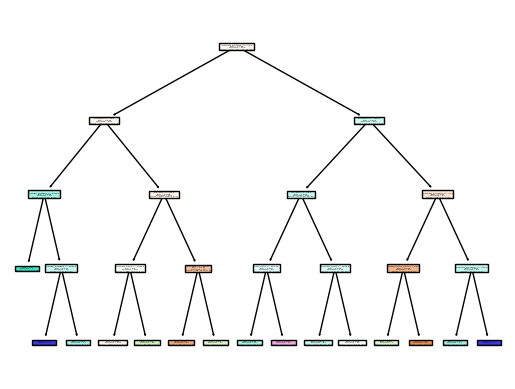

In [427]:
model: DecisionTreeClassifier = DecisionTreeClassifier(max_depth=4, random_state=1)
model.fit(X_train, y_train)
tree.plot_tree(model, feature_names=X.columns, filled=True)
plt.show()

### Test data to DataFrame and renamed

Hier zullen we de onafhankelijk test data naar een DataFrame omzetten en de kolom hernoemen.

In [428]:
df_pred = pd.DataFrame(model.predict(X_test))
df_pred = df_pred.rename(columns={0: "PREDICTED_RETURN_DESCRIPTION_EN"})
frame = pd.concat([y_test.reset_index()["RETURN_DESCRIPTION_EN"], df_pred], axis=1)
frame

,RETURN_DESCRIPTION_EN,PREDICTED_RETURN_DESCRIPTION_EN
0,Defective product,Incomplete product
1,Wrong product ordered,Wrong product shipped
2,Defective product,Defective product
3,Incomplete product,Defective product
4,Unsatisfactory product,Unsatisfactory product
...,...,...
66,Defective product,Incomplete product
67,Unsatisfactory product,Unsatisfactory product
68,Incomplete product,Defective product
69,Incomplete product,Defective product


### Confusion Matrix

We hebben hier een afbeelding met een Confusion Matrix, zodat er snel voorspellingen kunnen worden gemaakt

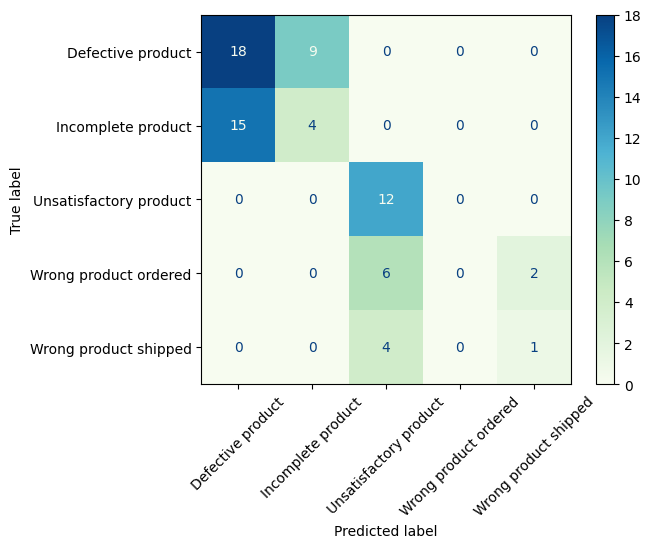

In [429]:
matrix = metrics.confusion_matrix(y_test, model.predict(X_test))

display: metrics.ConfusionMatrixDisplay = metrics.ConfusionMatrixDisplay(
    confusion_matrix=matrix, 
    display_labels=["Defective product", "Incomplete product", "Unsatisfactory product", "Wrong product ordered", "Wrong product shipped"]
)

display.plot(cmap="GnBu")
plt.xticks(rotation=45)
plt.show()

### Test the accuracy score

We kunnen nu meten hoe goed het model het heeft gedaan.

In [430]:
print(accuracy_score(frame["RETURN_DESCRIPTION_EN"], frame["PREDICTED_RETURN_DESCRIPTION_EN"]))

0.49295774647887325
